In [2]:
from netCDF4 import Dataset
import numpy as np
import dateutil.parser
import matplotlib.pyplot as plt
import os
from glob import glob
import tqdm
import pandas as pd
#import h5py
import datetime

In [3]:
sonde_dir = '../data/NP/rawinsondes_processed//'

filenames = [y for x in os.walk(sonde_dir) for y in glob(os.path.join(x[0], '*.h5'))]

In [4]:
filenames

['../data/NP/rawinsondes_processed/11_valid_sondes.h5',
 '../data/NP/rawinsondes_processed/08_valid_sondes.h5',
 '../data/NP/rawinsondes_processed/07_valid_sondes.h5',
 '../data/NP/rawinsondes_processed/19_valid_sondes.h5',
 '../data/NP/rawinsondes_processed/16_valid_sondes.h5',
 '../data/NP/rawinsondes_processed/17_valid_sondes.h5',
 '../data/NP/rawinsondes_processed/10_valid_sondes.h5',
 '../data/NP/rawinsondes_processed/09_valid_sondes.h5',
 '../data/NP/rawinsondes_processed/06_valid_sondes.h5',
 '../data/NP/rawinsondes_processed/22_valid_sondes.h5',
 '../data/NP/rawinsondes_processed/03_valid_sondes.h5',
 '../data/NP/rawinsondes_processed/28_valid_sondes.h5',
 '../data/NP/rawinsondes_processed/15_valid_sondes.h5',
 '../data/NP/rawinsondes_processed/31_valid_sondes.h5',
 '../data/NP/rawinsondes_processed/12_valid_sondes.h5',
 '../data/NP/rawinsondes_processed/04_valid_sondes.h5',
 '../data/NP/rawinsondes_processed/13_valid_sondes.h5',
 '../data/NP/rawinsondes_processed/21_valid_sond

In [5]:
list_of_details = []

for filename in filenames[:]:
    
    meta_df = pd.read_hdf(filename,key='metadata',mode='r')
    
    print(meta_df['station'].iloc[0])
    
    keys = meta_df['code']
    
    meta_df.set_index('code',inplace=True)

    for key in tqdm.tqdm(keys):
        
        sonde = pd.read_hdf(filename,key=key,mode='r')
        
        sonde = sonde[sonde['humidity']!=99.0]
        
        press = np.asarray(sonde['pressure'])
        alt = np.asarray(sonde['altitude'])
        temp = np.asarray(sonde['temperature'])
                              
        details = dict(meta_df.loc[key])     
                              
        # Calculate inversion strength and height
                              
        t0 = np.nanmedian(temp[(alt<10) & (alt>-10)])
        details['t0'] = t0
        details['inversion_height'] = alt[np.argmax(temp)]
        details['inversion_strength'] = np.nanmax(temp) - t0
                              
        # Calculate low level stability
        
        t850hpa = temp[np.argmin(np.abs(press-850))]
        
        ground_level_offset = np.nanmin(np.abs(alt-2))
        if ground_level_offset>10:
            lls=np.nan
        else:
            t2m = temp[np.argmin(np.abs(alt-2))]
            lls = t850hpa - t2m
  
        details['low_level_stability']=lls
    
        details['surf_wind_velocity'] = sonde.iloc[0]['A_WIND_SPD_QLTY']
        
        wind_850 = sonde.iloc[np.argmin(np.abs(press-850))]['A_WIND_SPD_QLTY']
        
        details['wind_shear'] = wind_850 - details['surf_wind_velocity']
    
    
#         rh = np.asarray(sonde['humidity'])/100
#         x = np.count_nonzero(np.nan_to_num(rh[press<851]))
#         if x>3:rh_sub_850 = np.nanmean(rh[press<851])
#         else: rh_sub_850 = np.nan
#         details['rh_sub_850']=rh_sub_850
        
        
        details['cloudiness'] = float(meta_df.loc[key]['CLOUD_AMOUNT'])
        details['cloud_quality'] = float(meta_df.loc[key]['CLOUD_AMOUNT_QLTY'])
        
    
        # Generate row of dataframe
        
        list_of_details.append(details)
        
#     break
        
df = pd.DataFrame(list_of_details)

ImportError: Missing optional dependency 'pytables'.  Use pip or conda to install pytables.

In [6]:
df.columns

Index(['station', 'SNT_IND', 'ELEV', 'year', 'month', 'day', 'GMT_hour',
       'GMT_minute', 'STD_GMT_TIME', 'local_time', 'RELSE_TIME', 'latitude',
       'longitude', 'min_altitude', 'max_altitude', 'OBSN_TYPE', 'QC_EFFORT',
       'DATA_SRCE', 'NUM_LVLS', 'INST_CODE', 'CLOUD_AMOUNT',
       'CLOUD_AMOUNT_QLTY', 'LOWER_CLOUD', 'CLOUD_HEIGHT', 'CLOUD_HEIGHT_QLTY',
       'MID_CLOUD', 'MID_CLOUD_QLTY', 'HIGH_CLOUD', 'HIGH_CLOUD_QLTY', 'date',
       'inversion_height', 'inversion_strength', 't0', 'npoints',
       'npoints_sub3000', 'low_level_stability', 'surf_wind_velocity',
       'wind_shear', 'cloudiness', 'cloud_quality'],
      dtype='object')

In [7]:
# df_c = df.dropna()

df_c = df

print(df.shape,df_c.shape)

# df_c = df_c[df['inversion_height'] < 10_000]

df_c = df_c[np.isin(df_c['month'], [9,10,11,12,1,2,3])]

print(df_c.shape)

df_c.to_csv('../data/tables/NP.csv')

(16539, 40) (16539, 40)
(9931, 40)


(array([825.,   4.,  27.,  14.,   6.,   7.,  18.,  28., 155.,   1.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

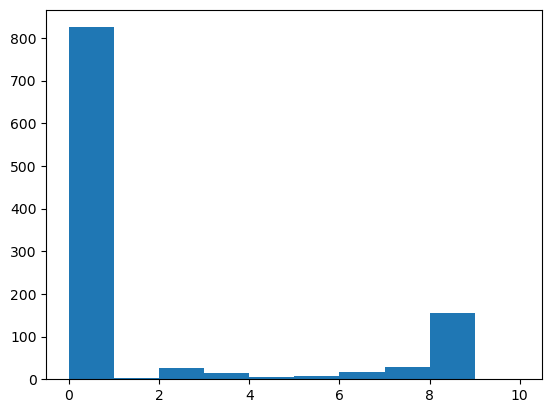

In [63]:
plt.hist(df_c['cloudiness'],bins=np.arange(0,10.1,1))

# Now add clear and cloudy information to the table

6


 22%|█████████                                | 188/852 [00:01<00:08, 75.71it/s]/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: All-NaN axis encountered
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: All-NaN axis encountered
 82%|████████████████████████████████▊       | 700/852 [00:05<00:01, 128.37it/s]/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: All-NaN axis encountered
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: All-NaN axis encountered
100%|████████████████████████████████████████| 852/852 [00:07<00:00, 115.66it/s]


(244, 608)

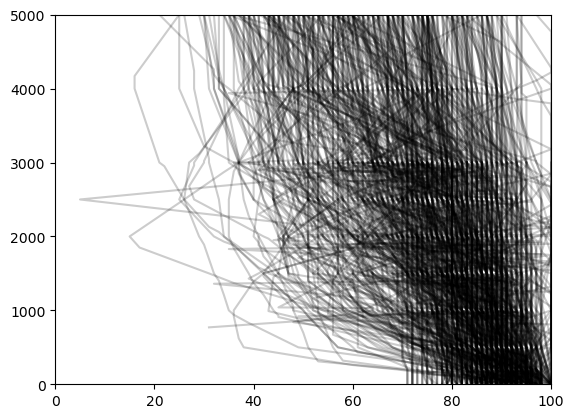

In [55]:
cloudy, clear = 0, 0

for filename in filenames[-1:]:
    
    meta_df = pd.read_hdf(filename,key='metadata',mode='r')
    
    print(meta_df['station'].iloc[0])
    
    keys = meta_df['code']
    
    meta_df.set_index('code',inplace=True)

    for key in tqdm.tqdm(keys):
        
        sonde = pd.read_hdf(filename,key=key,mode='r')
        
        sonde = sonde[sonde['pressure']>500]
        
        sonde = sonde[sonde['humidity']!=99.0]
        
        plt.plot(sonde['humidity'],sonde['altitude'],color='k',alpha=0.2)
        
        if np.nanmax(sonde['humidity']) > 84:
            cloudy+=1
        else:
            clear+=1
    break 
    
    
plt.xlim(0,100)
plt.ylim(0,5000)

clear,cloudy

In [48]:
cloudy, clear

(1290, 0)